In [87]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import time

In [88]:
ticker = 'SPY'
data = yf.download(ticker, start='2022-01-01', end='2025-03-15', progress=False)['Close']['SPY']
def price_barrier_option(option_type, K, barrier_price):
    daily_returns = data.pct_change().dropna()

    # Parámetros
    S0 = float(data.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    r = 0.10
    T_days = 252
    T = 1  # años
    dt = T / T_days
    num_simulations = 10000
    Z = np.random.normal(0, 1, (num_simulations, T_days))

    returns = (r - 0.5 * sigma**2) * dt  +  sigma * np.sqrt(dt) * Z
    prices = S0 * np.cumprod(1 + returns, axis=1)

    ST = prices[:, -1]

    barrier_breached = np.any(prices >= barrier_price, axis=1)

    if option_type == 'call':

        payoff_barrier = np.where(~barrier_breached, np.maximum(ST - K, 0), 0 )

        # Payoff opcion sin barrera
        payoff_plain = np.maximum(ST - K, 0)

    elif option_type == 'put':

        payoff_barrier = np.where(~barrier_breached, np.maximum(K - ST, 0), 0 )
        # Payoff opcion sin barrera
        payoff_plain = np.maximum(K - ST, 0)

    price_barrier = np.exp(-r * T) * np.mean(payoff_barrier)
    price_normal = np.exp(-r * T) * np.mean(payoff_plain)
    price_difference = price_normal - price_barrier

    return {
        'S0': S0
        ,'price_plain': price_normal
        ,'price_barrier': price_barrier
        ,'price_difference': price_difference
        }



In [89]:
price_barrier_option('put', 620, 621)

{'S0': 561.1220092773438,
 'price_plain': np.float64(42.9962658845841),
 'price_barrier': np.float64(31.444121825480366),
 'price_difference': np.float64(11.552144059103732)}

# Actividad

## 1. Con K, activo, y option_type fijo. Y para barrier_price desde 1\*K  hasta 1.2\*K. Grafica el precio de las opciones con y sin barrera.

In [90]:
k = 620
opt = 'put'
ticker = 'SPY'

price_barrier = []
price_plain = []

x = np.linspace(k, 1.2*k, 200)

for i in x:
    price_barrier.append(price_barrier_option(opt, k, i)['price_barrier'])
    price_plain.append(price_barrier_option(opt, k, i)['price_plain'])

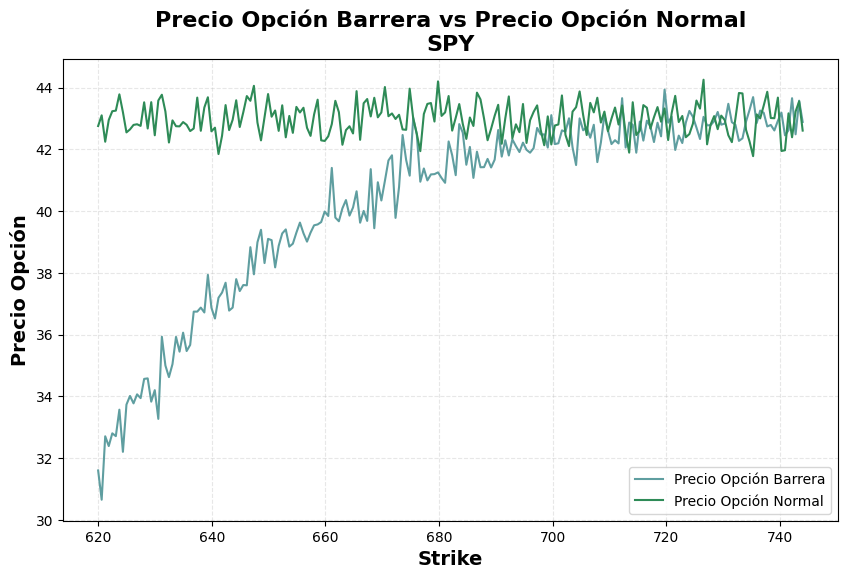

In [91]:
plt.figure(figsize=(10, 6))
plt.title(f'Precio Opción Barrera vs Precio Opción Normal\n{ticker}', fontsize=16, fontweight='bold')
plt.plot(x, price_barrier, c='cadetblue', label='Precio Opción Barrera')
plt.plot(x, price_plain, c='seagreen', label='Precio Opción Normal')
plt.xlabel('Strike', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Precio Opción', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.legend(loc='best')
plt.grid(alpha=0.3, linestyle='--')

Mientras más sube el precio strike el precio de la opción con barrera tiende a converger a la normal, dado que, a medida que sube el strike, la barrera dejará tener tanto impacto en el precio de la opción, y esto hace que convergan.

## 2. Compara el tiempo de cómputo para 1M de simulaciones entre la opción vectorizada y no vectorizada

### Funciones

In [92]:
ticker = 'SPY'
data = yf.download(ticker, start='2022-01-01', end='2025-03-15', progress=False)['Close']['SPY']

def vectorizada(option_type, data, K, barrier_price):
    daily_returns = data.pct_change().dropna()

    # Parámetros
    S0 = float(data.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    r = 0.10
    T_days = 252
    T = 1  # años
    dt = T / T_days
    num_simulations = 100_000
    Z = np.random.normal(0, 1, (num_simulations, T_days))

    returns = (r - 0.5 * sigma**2) * dt  +  sigma * np.sqrt(dt) * Z
    prices = S0 * np.cumprod(1 + returns, axis=1)

    ST = prices[:, -1]

    barrier_breached = np.any(prices >= barrier_price, axis=1)

    if option_type == 'call':

        payoff_barrier = np.where(~barrier_breached, np.maximum(ST - K, 0), 0 )

        # Payoff opcion sin barrera
        payoff_plain = np.maximum(ST - K, 0)

    elif option_type == 'put':

        payoff_barrier = np.where(~barrier_breached, np.maximum(K - ST, 0), 0 )
        # Payoff opcion sin barrera
        payoff_plain = np.maximum(K - ST, 0)

    price_barrier = np.exp(-r * T) * np.mean(payoff_barrier)
    price_normal = np.exp(-r * T) * np.mean(payoff_plain)
    price_difference = price_normal - price_barrier

    return {
        'S0': S0
        ,'price_plain': price_normal
        ,'price_barrier': price_barrier
        ,'price_difference': price_difference
        }

def no_vectorizada(option_type, data, K, barrier_price):
    daily_returns = data.pct_change().dropna()

    # Parámetros
    S0 = float(data.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    r = 0.10
    T_days = 252
    T = 1  # años
    dt = T / T_days
    num_simulations = 100_000
    # Simulaciones
    Z = np.random.normal(0, 1, (num_simulations, T_days))


    price_matrix = np.zeros((num_simulations, T_days + 1))
    payoffs = np.zeros(num_simulations)

    for i in range(num_simulations):
        path = [S0]
        barrier_breached = False
        for t in range(1, T_days + 1):
            St = path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[i, t-1])
            path.append(St)

            if St > barrier_price:  # up-and-out
                barrier_breached = True
                break


        if not barrier_breached:
            ST = path[-1]
            if option_type == 'put':
                payoffs[i] = max(K - ST, 0)
            else:
                payoffs[i] = max(ST - K, 0)

### Ejecución para 100,000 simulaciones (no son un millón para que no tarde tanto tiempo)

In [94]:
# Ejecución vectorizada
inicio_v = time.time()  # Marca el tiempo de inicio
option_v = vectorizada('put', data, 620, 621)
fin_v = time.time()  # Marca el tiempo de finalización
print(f"Tiempo de ejecución de la solución vectorizada: {fin_v - inicio_v:.4f} segundos")

# Ejecución no vectorizada
inicio_nv = time.time()  # Marca el tiempo de inicio
option_nv = no_vectorizada('put', data, 620, 621)
fin_nv = time.time()  # Marca el tiempo de finalización
print(f"Tiempo de ejecución de la solución NO vectorizada: {fin_nv - inicio_nv:.4f} segundos")
print(f'La función vectorizada es {((fin_nv - inicio_nv) / (fin_v - inicio_v)):.4f} veces más rápida que la no vectorizada')

Tiempo de ejecución de la solución vectorizada: 0.6618 segundos
Tiempo de ejecución de la solución NO vectorizada: 26.3409 segundos
La función vectorizada es 39.8029 veces más rápida que la no vectorizada
